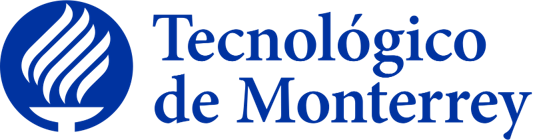

---
# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Movilidad Autónoma**
### Profesor Titular: Dr. David Antonio Torres
### Profesor Tutor: Iván Olmos Pineda

###Equipo 22:
* A01206674 - Isaac Manríquez Calderón
* A01568089 - Carlos Mario Jiménez Pizarro
* A01630948 - Mariana González Bravo
* A01793672 - Freddy Armendariz Herrera
* A01795050 - Julio César García Escoto
---

---
## **Actividad 3.1 - Detección de Peatones**


### **Importación de Librerías**

In [ ]:
# Descargar Data Set
# ====================================================================
import requests, zipfile
from io import BytesIO
#from zipfile import ZipFile
import glob

# Manipulación y Tratamiento de Datos
# ====================================================================
import pandas as pd
import numpy as np

# Gráficos
# ====================================================================
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de Imágenes
# ====================================================================
import cv2
from skimage.feature import hog

# Preprocesado y Modelado
# ====================================================================
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Lectura de Datasets**

https://github.com/vinay0410/Pedestrian_Detection/tree/master?tab=readme-ov-file

In [ ]:
#vehicle = glob.glob("/content/drive/MyDrive/Colab Notebooks/Movilidad Autonoma/Imagenes/data_svm/vehicles/**/*.png")
#no_vehicle = glob.glob("/content/drive/MyDrive/Colab Notebooks/Movilidad Autonoma/Imagenes/data_svm/non-vehicles/**/*.png")
pedestrian = glob.glob('/content/drive/MyDrive/Colab Notebooks/Movilidad Autonoma/Imagenes/train_64x128_H96/pos/*.png')
nopedestrian = glob.glob('/content/drive/MyDrive/Colab Notebooks/Movilidad Autonoma/Imagenes/train_64x128_H96/neg/*.png')

### **Descripción de Dataset**

In [ ]:
len(pedestrian)

2416

In [ ]:
len(nopedestrian)

912

### **Extracción de Features del HOG**

In [ ]:
def HOGFeatures(pictures, width=64, height=64):
  vehicle_hog_accum = []
  new_size = (width, height) #las imagenes se redimensionan a 64x64
  for i in pictures: # ciclo para la extraccion de las caracteristicas y la imagen hog
    #img_color = mpimg.imread(i)
    #img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_gray = cv2.imread(i,0) # Cambio a grises la imagen
    img_resized = cv2.resize(img_gray, new_size) # Redimension de la imagen
    #img_color = cv2.imread(i, cv2.IMREAD_COLOR)
    #img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    vehicle_hog_feature, vehicle_hog_img = hog(img_resized,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),#16*16
                                               cells_per_block = (2,2),#2*2
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    vehicle_hog_accum.append(vehicle_hog_feature)

  return vehicle_hog_accum

In [ ]:
pedestrians = HOGFeatures(pedestrian)

In [ ]:
X_pedestrians = np.vstack(pedestrians).astype(np.float64)
y_pedestrians = np.ones(len(X_pedestrians)) # Se asignan etiquetas de 1 a Y del tamaño del dataset a las imagenes que si se observan peatones.
print('Tamaño de X_pedestrians:',X_pedestrians.shape)
print('Tamaño de y_pedestrians:',y_pedestrians.shape)

Tamaño de X_pedestrians: (2416, 396)
Tamaño de y_pedestrians: (2416,)


In [ ]:
nopedestrians = HOGFeatures(nopedestrian)

In [ ]:
X_nopedestrians = np.vstack(nopedestrians).astype(np.float64)
y_nopedestrians = np.zeros(len(X_nopedestrians)) # Se asignan etiquetas de 0 a Y del tamaño del dataset a las imagenes donde no se observan peatones.
print('Tamaño de X_nopedestrians:',X_nopedestrians.shape)
print('Tamaño de y_nopedestrians:',y_nopedestrians.shape)

Tamaño de X_pedestrians: (912, 396)
Tamaño de y_pedestrians: (912,)


### **Combinación de Conjuntos de Datos**

In [ ]:
X = np.vstack((X_pedestrians,X_nopedestrians))
print('Tamaño de X:',X.shape)

Tamaño de X: (3328, 396)


In [ ]:
y = np.hstack((y_pedestrians,y_nopedestrians))
print('Tamaño de y:',y.shape)

Tamaño de y: (3328,)


### **Generación de Conjuntos de Entrenamiento y Prueba**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) #Se ajusta el tamaño de la muestra que se usara
# como prueba a 25% de los datos
print('Tamaño de X_train:',X_train.shape)
print('Tamaño de X_test:',X_test.shape)

Tamaño de X_train: (2496, 396)
Tamaño de X_test: (832, 396)


### **Entrenamiento del Clasificador SVM**

In [ ]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [ ]:
# Predicción de banderas con el conjunto de prueba
y_predict = svc_model.predict(X_test)

In [ ]:
# Definición de función para encontrar matriz de confusión

def mi_cm(yreal, ypred):

  cm = confusion_matrix(yreal, ypred)
  txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
  short = ["( VN )","( FP )","( FN )","( VP )"]
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(txt,short,frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=True)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

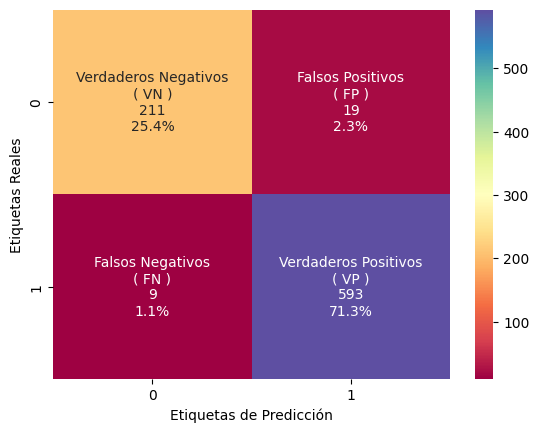

In [ ]:
# Matriz de Confusión para Evaluación del Modelo
mi_cm(y_test, y_predict)

In [ ]:
# Impresión de Métricas de Evaluación
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       230
         1.0       0.97      0.99      0.98       602

    accuracy                           0.97       832
   macro avg       0.96      0.95      0.96       832
weighted avg       0.97      0.97      0.97       832



### **Búsqueda de Hiperparámetros**

In [ ]:
# Definición de posibles parámetros
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [ ]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.764 total time=   1.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.762 total time=   1.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.760 total time=   2.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.749 total time=   4.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.752 total time=   1.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.908 total time=   0.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.872 total time=   0.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.890 total time=   1.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.884 total time=   0.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.860 total time=   0.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.726 total time=   1.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [ ]:
# Impresión de hiperparámetros
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [ ]:
# Generación de predicciones usando mejores hiperparámetros
grid_predictions = grid.predict(X_test)

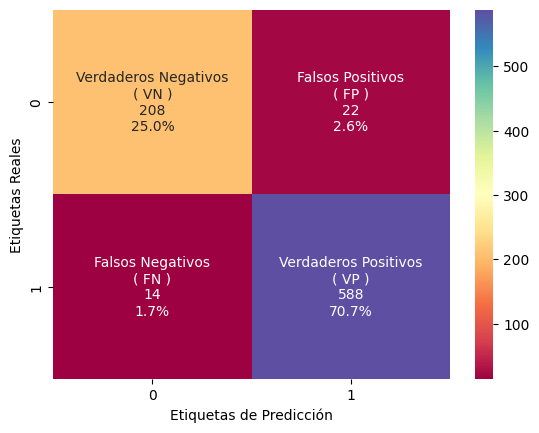

In [ ]:
# Matriz de Confusión para Evaluación de Modelo usando mejores Hiperparámetros
mi_cm(y_test, grid_predictions)

In [ ]:
# Impresión de Métricas de Evaluación
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       230
         1.0       0.96      0.98      0.97       602

    accuracy                           0.96       832
   macro avg       0.95      0.94      0.95       832
weighted avg       0.96      0.96      0.96       832





---
**La búsqueda de los mejores hiperparametos nos ayudan a reducir errores en las predicciones y a mejorar la precisión en el modelo, asimismo, nos ayudan a mejorar el balance entre el sesgo y la varianza evitando asi el underfitting u overfitting.**



---

